# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Create my_spark
spark = SparkSession.builder.getOrCreate()

## Check Version

Checking the version of which Spark and Python installed is important as it changes very quickly and drastically. Reading the wrong documentation can cause lots of lost time and unnecessary frustration!

In [2]:
# Return spark version
print(spark.version)

# Return python version
import sys
print(sys.version_info)

2.4.0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)


## Load in the data

Reading in data is the first step to using PySpark for data science! Let's leverage the new industry standard of parquet files!

In [45]:
# Read the file into a dataframe
# df = spark.read.parquet("Real_Estate.parq")
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('2017_StPaul_MN_Real_Estate.csv')

print(df.columns)
print(df.dtypes)
print(type(df))

['NO', 'MLSID', 'STREETNUMBERNUMERIC', 'STREETADDRESS', 'STREETNAME', 'POSTALCODE', 'STATEORPROVINCE', 'CITY', 'SALESCLOSEPRICE', 'LISTDATE', 'LISTPRICE', 'LISTTYPE', 'ORIGINALLISTPRICE', 'PRICEPERTSFT', 'FOUNDATIONSIZE', 'FENCE', 'MAPLETTER', 'LOTSIZEDIMENSIONS', 'SCHOOLDISTRICTNUMBER', 'DAYSONMARKET', 'OFFMARKETDATE', 'FIREPLACES', 'ROOMAREA4', 'ROOMTYPE', 'ROOF', 'ROOMFLOOR4', 'POTENTIALSHORTSALE', 'POOLDESCRIPTION', 'PDOM', 'GARAGEDESCRIPTION', 'SQFTABOVEGROUND', 'TAXES', 'ROOMFLOOR1', 'ROOMAREA1', 'TAXWITHASSESSMENTS', 'TAXYEAR', 'LIVINGAREA', 'UNITNUMBER', 'YEARBUILT', 'ZONING', 'STYLE', 'ACRES', 'COOLINGDESCRIPTION', 'APPLIANCES', 'BACKONMARKETDATE', 'ROOMFAMILYCHAR', 'ROOMAREA3', 'EXTERIOR', 'ROOMFLOOR3', 'ROOMFLOOR2', 'ROOMAREA2', 'DININGROOMDESCRIPTION', 'BASEMENT', 'BATHSFULL', 'BATHSHALF', 'BATHQUARTER', 'BATHSTHREEQUARTER', 'CLASS', 'BATHSTOTAL', 'BATHDESC', 'ROOMAREA5', 'ROOMFLOOR5', 'ROOMAREA6', 'ROOMFLOOR6', 'ROOMAREA7', 'ROOMFLOOR7', 'ROOMAREA8', 'ROOMFLOOR8', 'BEDROOM

## What are we predicting?

Which of these fields (or columns) is the value we are trying to predict for?

    TAXES
    SALESCLOSEPRICE
    DAYSONMARKET
    LISTPRICE


In [6]:
# Select our dependent variable
Y_df = df.select(['SALESCLOSEPRICE'])

# Display summary statistics
Y_df.describe()

DataFrame[summary: string, SALESCLOSEPRICE: string]

## Verifying Data Load

Let's suppose each month you get a new file. You know to expect a certain number of records and columns. In this exercise we will create a function that will validate the file loaded.

In [7]:
def check_load(df, num_records, num_columns):
  # Takes a dataframe and compares record and column counts to input
  # Message to return if the critera below aren't met
  message = 'Validation Failed'
  # Check number of records
  if num_records == df.count():
    # Check number of columns
    if num_columns == len(df.columns):
      # Success message
      message = 'Validation Passed'
  return message

# Print the data validation message
print(check_load(df, 5000, 74))

Validation Passed


## Verifying DataTypes

In the age of data we have access to more attributes than we ever had before. To handle all of them we will build a lot of automation but at a minimum requires that their datatypes be correct. In this exercise we will validate a dictionary of attributes and their datatypes to see if they are correct. This dictionary is stored in the variable validation_dict and is available in your workspace.

In [13]:
validation_dict = {'ASSESSMENTPENDING': 'string',
 'ASSESSEDVALUATION': 'double',
 'ASSOCIATIONFEE': 'int',
 'ASSUMABLEMORTGAGE': 'string',
 'SQFTBELOWGROUND': 'int'}

In [14]:
# Create list of actual dtypes to check
actual_dtypes_list = df.dtypes
print(actual_dtypes_list)

# Iterate through the list of actual dtypes tuples
for attribute_tuple in actual_dtypes_list:
  
  # Check if column name is dictionary of expected dtypes
  col_name = attribute_tuple[0]
  if col_name in validation_dict:

    # Compare attribute names and types
    col_type = attribute_tuple[1]
    if col_type == validation_dict[col_name]:
      print(col_name + ' has expected dtype.')

[('NO', 'int'), ('MLSID', 'string'), ('STREETNUMBERNUMERIC', 'int'), ('STREETADDRESS', 'string'), ('STREETNAME', 'string'), ('POSTALCODE', 'int'), ('STATEORPROVINCE', 'string'), ('CITY', 'string'), ('SALESCLOSEPRICE', 'int'), ('LISTDATE', 'string'), ('LISTPRICE', 'int'), ('LISTTYPE', 'string'), ('ORIGINALLISTPRICE', 'int'), ('PRICEPERTSFT', 'double'), ('FOUNDATIONSIZE', 'int'), ('FENCE', 'string'), ('MAPLETTER', 'string'), ('LOTSIZEDIMENSIONS', 'string'), ('SCHOOLDISTRICTNUMBER', 'string'), ('DAYSONMARKET', 'int'), ('OFFMARKETDATE', 'string'), ('FIREPLACES', 'int'), ('ROOMAREA4', 'string'), ('ROOMTYPE', 'string'), ('ROOF', 'string'), ('ROOMFLOOR4', 'string'), ('POTENTIALSHORTSALE', 'string'), ('POOLDESCRIPTION', 'string'), ('PDOM', 'int'), ('GARAGEDESCRIPTION', 'string'), ('SQFTABOVEGROUND', 'int'), ('TAXES', 'int'), ('ROOMFLOOR1', 'string'), ('ROOMAREA1', 'string'), ('TAXWITHASSESSMENTS', 'double'), ('TAXYEAR', 'int'), ('LIVINGAREA', 'int'), ('UNITNUMBER', 'string'), ('YEARBUILT', 'in

## Using Corr()

The old adage 'Correlation does not imply Causation' is a cautionary tale. However, correlation does give us a good nudge to know where to start looking promising features to use in our models. Use this exercise to get a feel for searching through your data for the first time, trying to find patterns.

A list called columns containing column names has been created for you. In this exercise you will compute the correlation between those columns and 'SALESCLOSEPRICE', and find the maximum.

In [15]:
columns = ['FOUNDATIONSIZE',
 'DAYSONMARKET',
 'FIREPLACES',
 'PDOM',
 'SQFTABOVEGROUND',
 'TAXES',
 'TAXWITHASSESSMENTS',
 'TAXYEAR',
 'LIVINGAREA',
 'YEARBUILT',
 'ACRES',
 'BACKONMARKETDATE',
 'BATHSFULL',
 'BATHSHALF',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'BATHSTOTAL',
 'BEDROOMS',
 'SQFTBELOWGROUND',
 'ASSOCIATIONFEE',
 'ASSESSEDVALUATION']

In [17]:
# Name and value of col with max corr
corr_max = 0
corr_max_col = columns[0]

# Loop to check all columns contained in list
for col in columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr('SALESCLOSEPRICE', col)
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

IllegalArgumentException: 'requirement failed: Currently correlation calculation for columns with dataType string not supported.'

## Using Visualizations: distplot

Understanding the distribution of our dependent variable is very important and can impact the type of model or preprocessing we do. A great way to do this is to plot it, however plotting is not a built in function in PySpark, we will need to take some intermediary steps to make sure it works correctly. In this exercise you will visualize the variable the 'LISTPRICE' variable, and you will gain more insights on its distribution by computing the skewness.

The matplotlib.pyplot and seaborn packages have been imported for you with aliases plt and sns.

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


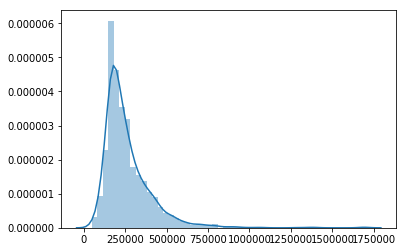

[Row(skewness(LISTPRICE)=2.790448093916559)]


In [18]:
# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas().astype(int)

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

## Using Visualizations: lmplot

Creating linear model plots helps us visualize if variables have relationships with the dependent variable. If they do they are good candidates to include in our analysis. If they don't it doesn't mean that we should throw them out, it means we may have to process or wrangle them before they can be used.

seaborn is available in your workspace with the customary alias sns.

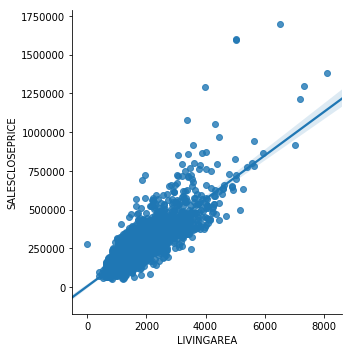

In [19]:
# Select a the relevant columns and sample
sample_df = df.select(['SALESCLOSEPRICE', 'LIVINGAREA']).sample(False, 0.5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas().astype(float)

# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)
plt.show()

# Wrangling with Spark Functions

## Dropping a list of columns

Our data set is rich with a lot of features, but not all are valuable. We have many that are going to be hard to wrangle into anything useful. For now, let's remove any columns that aren't immediately useful by dropping them.

    'STREETNUMBERNUMERIC': The postal address number on the home
    'FIREPLACES': Number of Fireplaces in the home
    'LOTSIZEDIMENSIONS': Free text describing the lot shape
    'LISTTYPE': Set list of values of sale type
    'ACRES': Numeric area of lot size


In [20]:
# Show top 30 records
df.show(30)

# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+---------------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+--------------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+--------------------+--------------------+-----+------------------+--------------------+----------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--

## Using text filters to remove records

It pays to have to ask your clients lots of questions and take time to understand your variables. You find out that Assumable mortgage is an unusual occurrence in the real estate industry and your client suggests you exclude them. In this exercise we will use isin() which is similar to like() but allows us to pass a list of values to use as a filter rather than a single one.

In [21]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.where(text_filter)

# print count of remaining records
print(df.count())

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+

4976


## Filtering numeric fields conditionally

Again, understanding the context of your data is extremely important. We want to understand what a normal range of houses sell for. Let's make sure we exclude any outlier homes that have sold for significantly more or less than the average. Here we will calculate the mean and standard deviation and use them to filer the near normal field log_SalesClosePrice.

In [22]:
from pyspark.sql.functions import mean, stddev

# Calculate values used for outlier filtering
mean_val = df.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))

AnalysisException: 'Cannot resolve column name "log_SalesClosePrice" among (NO, MLSID, STREETADDRESS, STREETNAME, POSTALCODE, STATEORPROVINCE, CITY, SALESCLOSEPRICE, LISTDATE, LISTPRICE, LISTTYPE, ORIGINALLISTPRICE, PRICEPERTSFT, FOUNDATIONSIZE, FENCE, MAPLETTER, SCHOOLDISTRICTNUMBER, DAYSONMARKET, OFFMARKETDATE, FIREPLACES, ROOMAREA4, ROOMTYPE, ROOF, ROOMFLOOR4, POTENTIALSHORTSALE, POOLDESCRIPTION, PDOM, GARAGEDESCRIPTION, SQFTABOVEGROUND, TAXES, ROOMFLOOR1, ROOMAREA1, TAXWITHASSESSMENTS, TAXYEAR, LIVINGAREA, UNITNUMBER, YEARBUILT, ZONING, STYLE, ACRES, COOLINGDESCRIPTION, APPLIANCES, BACKONMARKETDATE, ROOMFAMILYCHAR, ROOMAREA3, EXTERIOR, ROOMFLOOR3, ROOMFLOOR2, ROOMAREA2, DININGROOMDESCRIPTION, BASEMENT, BATHSFULL, BATHSHALF, BATHQUARTER, BATHSTHREEQUARTER, CLASS, BATHSTOTAL, BATHDESC, ROOMAREA5, ROOMFLOOR5, ROOMAREA6, ROOMFLOOR6, ROOMAREA7, ROOMFLOOR7, ROOMAREA8, ROOMFLOOR8, BEDROOMS, SQFTBELOWGROUND, ASSUMABLEMORTGAGE, ASSOCIATIONFEE, ASSESSMENTPENDING, ASSESSEDVALUATION);'

## Custom Percentage Scaling

In the slides we showed how to scale the data between 0 and 1. Sometimes you may wish to scale things differently for modeling or display purposes.

In [25]:
# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentage_scaled_days', 
                  ((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)

# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


## Scaling your scalers

In the previous exercise, we minmax scaled a single variable. Suppose you have a LOT of variables to scale, you don't want hundreds of lines to code for each. Let's expand on the previous exercise and make it a function.

In [27]:
cols_to_scale = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']

In [28]:
def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
  for col in cols_to_scale:
    # Define min and max values and collect them
    max_days = df.agg({col: 'max'}).collect()[0][0]
    min_days = df.agg({col: 'min'}).collect()[0][0]
    new_column_name = 'scaled_' + col
    # Create a new column based off the scaled data
    df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
  return df
  
df = min_max_scaler(df, cols_to_scale)
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



## Correcting Right Skew Data

In the slides we showed how you might use log transforms to fix positively skewed data (data whose distribution is mostly to the left). To correct negative skew (data mostly to the right) you need to take an extra step called "reflecting" before you can apply the inverse of log
, written as (1/log) to make the data look more like normal a normal distribution. Reflecting data uses the following formula to reflect each value: (xmax+1)–x.

In [29]:
from pyspark.sql.functions import log

# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.25060307835912676)]


## Visualizing Missing Data

Being able to plot missing values is a great way to quickly understand how much of your data is missing. It can also help highlight when variables are missing in a pattern something that will need to be handled with care lest your model be biased.

Which variable has the most missing values? Run all lines of code except the last one to determine the answer. Once you're confident, and fill out the value and hit "Submit Answer".

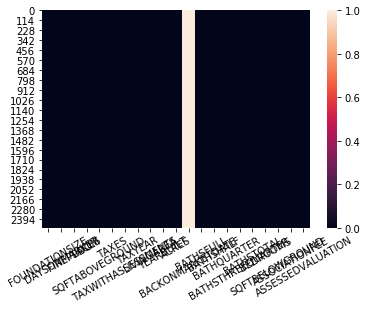

In [30]:
# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

## Imputing Missing Data

Missing data happens. If we make the assumption that our data is missing completely at random, we are making the assumption that what data we do have, is a good representation of the population. If we have a few values we could remove them or we could use the mean or median as a replacement. In this exercise, we will look at 'PDOM': Days on Market at Current Price.

In [31]:
# Count missing rows
missing = df.where(df['PDOM'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df.fillna(col_mean, subset=['PDOM'])

DataFrame[NO: int, MLSID: string, STREETADDRESS: string, STREETNAME: string, POSTALCODE: int, STATEORPROVINCE: string, CITY: string, SALESCLOSEPRICE: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, ORIGINALLISTPRICE: int, PRICEPERTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MAPLETTER: string, SCHOOLDISTRICTNUMBER: string, DAYSONMARKET: int, OFFMARKETDATE: string, FIREPLACES: int, ROOMAREA4: string, ROOMTYPE: string, ROOF: string, ROOMFLOOR4: string, POTENTIALSHORTSALE: string, POOLDESCRIPTION: string, PDOM: int, GARAGEDESCRIPTION: string, SQFTABOVEGROUND: int, TAXES: int, ROOMFLOOR1: string, ROOMAREA1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LIVINGAREA: int, UNITNUMBER: string, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, COOLINGDESCRIPTION: string, APPLIANCES: string, BACKONMARKETDATE: string, ROOMFAMILYCHAR: string, ROOMAREA3: string, EXTERIOR: string, ROOMFLOOR3: string, ROOMFLOOR2: string, ROOMAREA2: string, DININGROOMDESCRIPTION: string, BA

## Calculate Missing Percents

Automation is the future of data science. Learning to automate some of your data preparation pays dividends. In this exercise, we will automate dropping columns if they are missing data beyond a specific threshold.

In [32]:
def column_dropper(df, threshold):
  # Takes a dataframe and threshold for missing values. Returns a dataframe.
  total_records = df.count()
  for col in df.columns:
    # Calculate the percentage of missing values
    missing = df.where(df[col].isNull()).count()
    missing_percent = missing / total_records
    # Drop column if percent of missing is more than threshold
    if missing_percent > threshold:
      df = df.drop(col)
  return df

# Drop columns that are more than 60% missing
df = column_dropper(df, .6)

## A Dangerous Join

In this exercise, we will be joining on Latitude and Longitude to bring in another dataset that measures how walk-friendly a neighborhood is. We'll need to be careful to make sure our joining columns are the same data type and ensure we are joining on the same precision (number of digits after the decimal) or our join won't work!

Below you will find that df['latitude'] and df['longitude'] are at a higher precision than walk_df['longitude'] and walk_df['latitude'] we'll need to round them to the same precision so the join will work correctly.

In [40]:
print(type('sfsdsf'))

<class 'str'>


In [44]:
walk_df = spark.DataFrame['latitude': float, 'longitude': float, 'walkscore': int, 'bikescore': int, 'transitscore': str]

AttributeError: 'SparkSession' object has no attribute 'DataFrame'

In [33]:
# Cast data types
walk_df = walk_df.withColumn('longitude', walk_df['longitude'].cast('double'))
walk_df = walk_df.withColumn('latitude', walk_df['latitude'].cast('double'))

# Round percision
df = df.withColumn('longitude', round(df['longitude'], 5))
df = df.withColumn('latitude', round(df['latitude'], 5))

# Create join condition
condition = [(df['longitude'] == walk_df['longitude']), (df['latitude'] == walk_df['latitude'])]

# Join the dataframes together
join_df = df.join(walk_df, on=condition, how='left')
# Count non-null records from new field
print(join_df.where(~join_df['walkscore'].isNull()).count())

NameError: name 'walk_df' is not defined

## Spark SQL Join

Sometimes it is much easier to write complex joins in SQL. In this exercise, we will start with the join keys already in the same format and precision but will use SparkSQL to do the joining.

In [47]:
# Register dataframes as tables
df.createOrReplaceTempView("df")
walk_df.createOrReplaceTempView("walk_df")

# SQL to join dataframes
join_sql = 	"""
			SELECT 
				*
			FROM df
			LEFT JOIN walk_df
			ON df.longitude = walk_df.longitude
			AND df.latitude = walk_df.latitude
			"""
# Perform sql join
joined_df = spark.sql(join_sql)

NameError: name 'walk_df' is not defined

## Checking for Bad Joins

Joins can go bad silently if we are careful, meaning they will not error out but instead return mangled data with more or less data than you'd intended. Let's take a look at a couple ways that joining incorrectly can change your data set for the worse.

In this example we will look at what happens if you join two dataframes together when the join keys are not the same precision and compare the record counts between the correct join and the incorrect one.

In [48]:
# Join on mismatched keys precision 
wrong_prec_cond = [df_orig['longitude'] == walk_df['longitude'], df_orig['latitude'] == walk_df['latitude']]
wrong_prec_df = df_orig.join(walk_df, on=wrong_prec_cond, how='left')

# Compare bad join to the correct one
print(wrong_prec_df.where(wrong_prec_df['walkscore'].isNull()).count())
print(correct_join_df.where(correct_join_df['walkscore'].isNull()).count())

# Create a join on too few keys
few_keys_cond = [df['longitude'] == walk_df['longitude']]
few_keys_df = df.join(walk_df, on=few_keys_cond, how='left')

# Compare bad join to the correct one
print("Record Count of the Too Few Keys Join Example: " + str(few_keys_df.count()))
print("Record Count of the Correct Join Example: " + str(correct_join_df.count()))

NameError: name 'df_orig' is not defined

# Feature Engineering

## Differences

Let's explore generating features using existing ones. In the midwest of the U.S. many single family homes have extra land around them for green space. In this example you will create a new feature called 'YARD_SIZE', and then see if the new feature is correlated with our outcome variable.

In [49]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('ACRES', 'SALESCLOSEPRICE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SALESCLOSEPRICE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SALESCLOSEPRICE')))

Corr of ACRES vs SALESCLOSEPRICE: 0.22060612588935327
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.6152231695664401
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20714585430854263


## Ratios

Ratios are all around us. Whether it's miles per gallon or click through rate, they are everywhere. In this exercise, we'll create some ratios by dividing out pairs of columns.

In [50]:
# ASSESSED_TO_LIST
df = df.withColumn('ASSESSED_TO_LIST', df['ASSESSEDVALUATION'] / df['LISTPRICE'])
df[['ASSESSED_TO_LIST', 'ASSESSEDVALUATION', 'LISTPRICE']].show(5)
# TAX_TO_LIST
df = df.withColumn('TAX_TO_LIST', df['TAXES'] / df['LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)
# BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS'] / df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+----------------+-----------------+---------+
|ASSESSED_TO_LIST|ASSESSEDVALUATION|LISTPRICE|
+----------------+-----------------+---------+
|             0.0|              0.0|   139900|
|             0.0|              0.0|   210000|
|             0.0|              0.0|   225000|
|             0.0|              0.0|   230000|
|             0.0|              0.0|   239900|
+----------------+-----------------+---------+
only showing top 5 rows

+--------------------+-----+---------+
|         TAX_TO_LIST|TAXES|LISTPRICE|
+--------------------+-----+---------+
|0.013280914939242315| 1858|   139900|
| 0.00780952380952381| 1640|   210000|
|0.010622222222222222| 2390|   225000|
|0.009330434782608695| 2146|   230000|
|0.008378491037932471| 2010|   239900|
+--------------------+-----+---------+
only showing top 5 rows

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|       3|         2|
|1.333333333

## Deeper Features

In previous exercises we showed how combining two features together can create good additional features for a predictive model. In this exercise, you will generate 'deeper' features by combining the effects of three variables into one. Then you will check to see if deeper and more complicated features always make for better predictors.

In [53]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               5000|
|   mean| 1.4302617483739894|
| stddev|  14.12890410245937|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


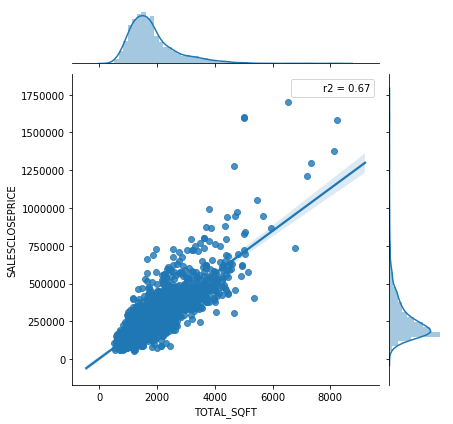

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


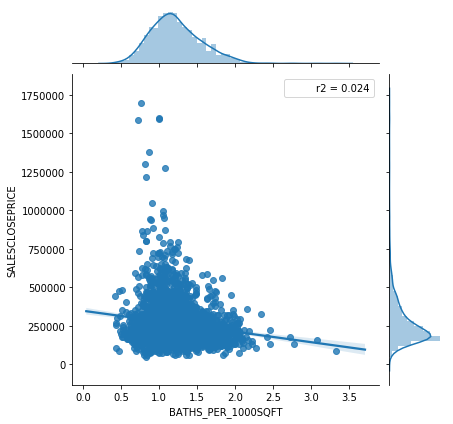

In [55]:
# Create new feature by adding two features together
df = df.withColumn('TOTAL_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['TOTAL_SQFT'] / 1000))
df[['BATHS_PER_1000SQFT']].describe().show()

# Pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

# Linear model plots
sns.jointplot(x='TOTAL_SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)
plt.show()
sns.jointplot(x='BATHS_PER_1000SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)
plt.show()

## Time Components

Being able to work with time components for building features is important but you can also use them to explore and understand your data further. In this exercise, you'll be looking to see if there is a pattern to which day of the week a house lists on. Please keep in mind that PySpark's week starts on Sunday, with a value of 1 and ends on Saturday, a value of 7.

In [57]:
# Import needed functions
from pyspark.sql.functions import to_date, dayofweek

# Convert to date type
df = df.withColumn('LISTDATE', to_date('LISTDATE'))

# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE'))

# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

# Plot count plot of of day of week
ax = sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

ValueError: min() arg is an empty sequence

## Joining On Time Components

Often times you will use date components to join in other sets of information. However, in this example, we need to use data that would have been available to those considering buying a house. This means we will need to use the previous year's reporting data for our analysis.

In [59]:
from pyspark.sql.functions import year

# Create year column
df = df.withColumn('list_year', year('LISTDATE'))

# Adjust year to match
df = df.withColumn('report_year', (df['list_year'] - 1))

# Create join condition
condition = [df['CITY'] == price_df['City'], df['report_year'] == price_df['Year']]

# Join the dataframes together
df = df.join(price_df, on=condition, how='left')
# Inspect that new columns are available
df[['MedianHomeValue']].show()

NameError: name 'price_df' is not defined

## Date Math

In this example, we'll look at verifying the frequency of our data. The Mortgage dataset is supposed to have weekly data but let's make sure by lagging the report date and then taking the difference of the dates.

Recall that to create a lagged feature we will need to create a window(). window() allows you to return a value for each record based off some calculation against a group of records, in this case, the previous period's mortgage rate.

In [60]:
from pyspark.sql.functions import lag, datediff, to_date
from pyspark.sql.window import Window

# Cast data type
mort_df = mort_df.withColumn('DATE', to_date('DATE'))

# Create window
w = Window().orderBy(mort_df['DATE'])
# Create lag column
mort_df = mort_df.withColumn('DATE-1', lag('DATE', count=1).over(w))

# Calculate difference between date columns
mort_df = mort_df.withColumn('Days_Between_Report', datediff('DATE', 'DATE-1'))
# Print results
mort_df.select('Days_Between_Report').distinct().show()

NameError: name 'mort_df' is not defined

## Extracting Text to New Features

Garages are an important consideration for houses in Minnesota where most people own a car and the snow is annoying to clear off a car parked outside. The type of garage is also important, can you get to your car without braving the cold or not? Let's look at creating a feature has_attached_garage that captures whether the garage is attached to the house or not.

In [61]:
# Import needed functions
from pyspark.sql.functions import when

# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')

# Conditional value assignment 
df = df.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                          .when(has_detached_garage, 0)
                                          .otherwise(None)))

# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(truncate=100)

+------------------------------------------------------------------+-------------------+
|                                                 GARAGEDESCRIPTION|has_attached_garage|
+------------------------------------------------------------------+-------------------+
|                                                   Attached Garage|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|    Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                               Attached Garage, Driveway - Asphalt|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|                    

## Splitting & Exploding

Being able to take a compound field like GARAGEDESCRIPTION and massaging it into something useful is an involved process. It's helpful to understand early what value you might gain out of expanding it. In this example, we will convert our string to a list-like array, explode it and then inspect the unique values.

In [62]:
# Import needed functions
from pyspark.sql.functions import split, explode

# Convert string to list-like array
df = df.withColumn('garage_list', split(df['GARAGEDESCRIPTION'], ', '))

# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', explode(df['garage_list']))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(100, truncate=50)

+----------------------------+
|              ex_garage_list|
+----------------------------+
|             Attached Garage|
|      On-Street Parking Only|
|                        None|
| More Parking Onsite for Fee|
|          Garage Door Opener|
|   No Int Access to Dwelling|
|           Driveway - Gravel|
|       Valet Parking for Fee|
|              Uncovered/Open|
|               Heated Garage|
|          Underground Garage|
|                       Other|
|                  Unassigned|
|More Parking Offsite for Fee|
|    Driveway - Other Surface|
|       Contract Pkg Required|
|                     Carport|
|                     Secured|
|             Detached Garage|
|          Driveway - Asphalt|
|                  Units Vary|
|                    Assigned|
|                   Tuckunder|
|                     Covered|
|            Insulated Garage|
|         Driveway - Concrete|
|                      Tandem|
|           Driveway - Shared|
+----------------------------+



## Pivot & Join

Being able to explode and pivot a compound field is great, but you are left with a dataframe of only those pivoted values. To really be valuable you'll need to rejoin it to the original dataset! After joining the datasets we will have a lot of NULL values for the newly created columns since we know the context of how they were created we can safely fill them in with zero as either the new has an attribute or it doesn't.

In [63]:
from pyspark.sql.functions import coalesce, first

# Pivot 
piv_df = ex_df.groupBy('NO').pivot('ex_garage_list').agg(coalesce(first('constant_val')))

# Join the dataframes together and fill null
joined_df = df.join(piv_df, on='NO', how='left')

# Columns to zero fill
zfill_cols = piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)

AnalysisException: "cannot resolve '`constant_val`' given input columns: [LISTPRICE, BATHS_PER_1000SQFT, LOT_SIZE_SQFT, MAPLETTER, POTENTIALSHORTSALE, BATHSTOTAL, ROOMFAMILYCHAR, ROOMFLOOR5, ROOMFLOOR2, BED_TO_BATHS, UNITNUMBER, ex_garage_list, YEARBUILT, ASSESSEDVALUATION, ASSESSED_TO_LIST, ACRES, CLASS, OFFMARKETDATE, ROOMFLOOR8, PDOM, ROOMAREA7, PRICEPERTSFT, SALESCLOSEPRICE, LOTSIZEDIMENSIONS, DAYSONMARKET, TAX_TO_LIST, CITY, BATHDESC, LISTDATE, FIREPLACES, TOTAL_SQFT, SQFTABOVEGROUND, ASSESSMENTPENDING, ROOMFLOOR6, ROOMTYPE, TAXES, ROOMAREA3, ROOMAREA5, ROOMAREA8, POOLDESCRIPTION, BATHSHALF, ROOMAREA4, BATHQUARTER, POSTALCODE, DININGROOMDESCRIPTION, BASEMENT, report_year, list_year, ROOMFLOOR4, ORIGINALLISTPRICE, BACKONMARKETDATE, STREETNAME, COOLINGDESCRIPTION, SQFTBELOWGROUND, APPLIANCES, SCHOOLDISTRICTNUMBER, ROOMFLOOR1, ROOMFLOOR7, ZONING, garage_list, ROOMFLOOR3, NO, TAXWITHASSESSMENTS, BEDROOMS, YARD_SIZE, TAXYEAR, STREETNUMBERNUMERIC, FOUNDATIONSIZE, LISTTYPE, ASSOCIATIONFEE, MLSID, GARAGEDESCRIPTION, ROOMAREA6, BATHSTHREEQUARTER, FENCE, STYLE, ROOF, ROOMAREA2, EXTERIOR, STREETADDRESS, List_Day_of_Week, has_attached_garage, ROOMAREA1, STATEORPROVINCE, LIVINGAREA, BATHSFULL, ASSUMABLEMORTGAGE];;\n'Pivot ArrayBuffer(NO#11224), ex_garage_list#14375: string, [Assigned, Attached Garage, Carport, Contract Pkg Required, Covered, Detached Garage, Driveway - Asphalt, Driveway - Concrete, Driveway - Gravel, Driveway - Other Surface, Driveway - Shared, Garage Door Opener, Heated Garage, Insulated Garage, More Parking Offsite for Fee, More Parking Onsite for Fee, No Int Access to Dwelling, None, On-Street Parking Only, Other, Secured, Tandem, Tuckunder, Unassigned, ... 4 more fields], [coalesce(first('constant_val, false))]\n+- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#13607, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 63 more fields]\n   +- Generate explode(garage_list#14287), false, [ex_garage_list#14375]\n      +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#13607, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 62 more fields]\n         +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#13607, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 61 more fields]\n            +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#13607, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n               +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#13607, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                  +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#13607, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                     +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#13607, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                        +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#13607, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                           +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, to_date('LISTDATE, None) AS LISTDATE#13607, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                              +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#13363, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                                 +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, to_date('LISTDATE, None) AS LISTDATE#13363, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                                    +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#12520, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                                       +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#12520, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                                          +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#12520, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                                             +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#12520, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                                                +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#12520, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 60 more fields]\n                                                   +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, to_date('LISTDATE, None) AS LISTDATE#12520, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 59 more fields]\n                                                      +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#11233, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 59 more fields]\n                                                         +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#11233, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 58 more fields]\n                                                            +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#11233, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 57 more fields]\n                                                               +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#11233, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 56 more fields]\n                                                                  +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#11233, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 55 more fields]\n                                                                     +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#11233, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 54 more fields]\n                                                                        +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#11233, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 53 more fields]\n                                                                           +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#11233, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 52 more fields]\n                                                                              +- Project [NO#11224, MLSID#11225, STREETNUMBERNUMERIC#11226, STREETADDRESS#11227, STREETNAME#11228, POSTALCODE#11229, STATEORPROVINCE#11230, CITY#11231, SALESCLOSEPRICE#11232, LISTDATE#11233, LISTPRICE#11234, LISTTYPE#11235, ORIGINALLISTPRICE#11236, PRICEPERTSFT#11237, FOUNDATIONSIZE#11238, FENCE#11239, MAPLETTER#11240, LOTSIZEDIMENSIONS#11241, SCHOOLDISTRICTNUMBER#11242, DAYSONMARKET#11243, OFFMARKETDATE#11244, FIREPLACES#11245, ROOMAREA4#11246, ROOMTYPE#11247, ... 51 more fields]\n                                                                                 +- Relation[NO#11224,MLSID#11225,STREETNUMBERNUMERIC#11226,STREETADDRESS#11227,STREETNAME#11228,POSTALCODE#11229,STATEORPROVINCE#11230,CITY#11231,SALESCLOSEPRICE#11232,LISTDATE#11233,LISTPRICE#11234,LISTTYPE#11235,ORIGINALLISTPRICE#11236,PRICEPERTSFT#11237,FOUNDATIONSIZE#11238,FENCE#11239,MAPLETTER#11240,LOTSIZEDIMENSIONS#11241,SCHOOLDISTRICTNUMBER#11242,DAYSONMARKET#11243,OFFMARKETDATE#11244,FIREPLACES#11245,ROOMAREA4#11246,ROOMTYPE#11247,... 50 more fields] csv\n"

## Binarizing Day of Week

In a previous video, we saw that it was very unlikely for a home to list on the weekend. Let's create a new field that says if the house is listed for sale on a weekday or not. In this example there is a field called List_Day_of_Week that has Monday is labeled 1.0 and Sunday is 7.0. Let's convert this to a binary field with weekday being 0 and weekend being 1. We can use the pyspark feature transformer Binarizer to do this.

In [64]:
# Import transformer
from pyspark.ml.feature import Binarizer

# Create the transformer
binarizer = Binarizer(threshold=5.0, inputCol='List_Day_of_Week', outputCol='Listed_On_Weekend')

# Apply the transformation to df
df = binarizer.transform(df)

# Verify transformation
df[['List_Day_of_Week', 'Listed_On_Weekend']].show()

IllegalArgumentException: 'Data type IntegerType is not supported.'

## Bucketing

If you are a homeowner its very important if a house has 1, 2, 3 or 4 bedrooms. But like bathrooms, once you hit a certain point you don't really care whether the house has 7 or 8. This example we'll look at how to figure out where are some good value points to bucket.

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

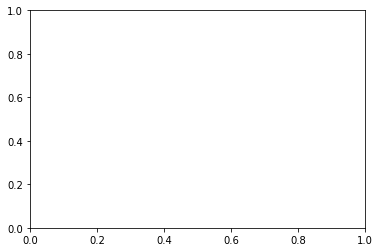

In [65]:
from pyspark.ml.feature import Bucketizer

# Plot distribution of sample_df
sns.distplot(sample_df, axlabel='BEDROOMS')
plt.show()

# Create the bucket splits and bucketizer
splits = [0, 1, 2, 3, 4, 5, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='BEDROOMS', outputCol='bedrooms')

# Apply the transformation to df
df = buck.transform(df)

# Display results
df[['BEDROOMS', 'bedrooms']].show()

## One Hot Encoding

In the United States where you live determines which schools your kids can attend. Therefore it's understandable that many people care deeply about which school districts their future home will be in. While the school districts are numbered in SCHOOLDISTRICTNUMBER they are really categorical. Meaning that summing or averaging these values has no apparent meaning. Therefore in this example we will convert SCHOOLDISTRICTNUMBER from a categorial variable into a numeric vector to use in our machine learning model later.

In [66]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SCHOOLDISTRICTNUMBER', outputCol='School_Index')
indexed_df = string_indexer.fit(df).transform(df)

# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
encoded_df = encoder.transform(indexed_df)

# Inspect the transformation steps
encoded_df[['SCHOOLDISTRICTNUMBER', 'School_Index', 'School_Vec']].show(truncate=100)

+-----------------------------+------------+-------------+
|         SCHOOLDISTRICTNUMBER|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0]

# Building a Model

## Creating Time Splits

In the video, we learned why splitting data randomly can be dangerous for time series as data from the future can cause overfitting in our model. Often with time series, you acquire new data as it is made available and you will want to retrain your model using the newest data. In the video, we showed how to do a percentage split for test and training sets but suppose you wish to train on all available data except for the last 45days which you want to use for a test set.

In this exercise, we will create a function to find the split date for using the last 45 days of data for testing and the rest for training. Please note that timedelta() has already been imported for you from the standard python library datetime.

In [67]:
def train_test_split_date(df, split_col, test_days=45):
  """Calculate the date to split test and training sets"""
  # Find how many days our data spans
  max_date = df.agg({split_col: 'max'}).collect()[0][0]
  min_date = df.agg({split_col: 'min'}).collect()[0][0]
  # Subtract an integer number of days from the last date in dataset
  split_date = max_date - timedelta(days=test_days)
  return split_date

# Find the date to use in spitting test and train
split_date = train_test_split_date(df, 'OFFMKTDATE')

# Create Sequential Test and Training Sets
train_df = df.where(df['OFFMKTDATE'] < split_date)
test_df = df.where(df['OFFMKTDATE'] >= split_date).where(df['LISTDATE'] <= split_date) 

AnalysisException: 'Cannot resolve column name "OFFMKTDATE" among (NO, MLSID, STREETNUMBERNUMERIC, STREETADDRESS, STREETNAME, POSTALCODE, STATEORPROVINCE, CITY, SALESCLOSEPRICE, LISTDATE, LISTPRICE, LISTTYPE, ORIGINALLISTPRICE, PRICEPERTSFT, FOUNDATIONSIZE, FENCE, MAPLETTER, LOTSIZEDIMENSIONS, SCHOOLDISTRICTNUMBER, DAYSONMARKET, OFFMARKETDATE, FIREPLACES, ROOMAREA4, ROOMTYPE, ROOF, ROOMFLOOR4, POTENTIALSHORTSALE, POOLDESCRIPTION, PDOM, GARAGEDESCRIPTION, SQFTABOVEGROUND, TAXES, ROOMFLOOR1, ROOMAREA1, TAXWITHASSESSMENTS, TAXYEAR, LIVINGAREA, UNITNUMBER, YEARBUILT, ZONING, STYLE, ACRES, COOLINGDESCRIPTION, APPLIANCES, BACKONMARKETDATE, ROOMFAMILYCHAR, ROOMAREA3, EXTERIOR, ROOMFLOOR3, ROOMFLOOR2, ROOMAREA2, DININGROOMDESCRIPTION, BASEMENT, BATHSFULL, BATHSHALF, BATHQUARTER, BATHSTHREEQUARTER, CLASS, BATHSTOTAL, BATHDESC, ROOMAREA5, ROOMFLOOR5, ROOMAREA6, ROOMFLOOR6, ROOMAREA7, ROOMFLOOR7, ROOMAREA8, ROOMFLOOR8, BEDROOMS, SQFTBELOWGROUND, ASSUMABLEMORTGAGE, ASSOCIATIONFEE, ASSESSMENTPENDING, ASSESSEDVALUATION, list_year, report_year, LOT_SIZE_SQFT, YARD_SIZE, ASSESSED_TO_LIST, TAX_TO_LIST, BED_TO_BATHS, TOTAL_SQFT, BATHS_PER_1000SQFT, List_Day_of_Week, has_attached_garage, garage_list);'

## Adjusting Time Features

We have mentioned throughout this course some of the dangers of leaking information to your model during training. Data leakage will cause your model to have very optimistic metrics for accuracy but once real data is run through it the results are often very disappointing.

In this exercise, we are going to ensure that DAYSONMARKET only reflects what information we have at the time of predicting the value. I.e., if the house is still on the market, we don't know how many more days it will stay on the market. We need to adjust our test_df to reflect what information we currently have as of 2017-12-10.

NOTE: This example will use the lit() function. This function is used to allow single values where an entire column is expected in a function call.

In [68]:
from pyspark.sql.functions import datediff, to_date, lit

split_date = to_date(lit('2017-12-10'))
# Create Sequential Test set
test_df = df.where(df['OFFMKTDATE'] >= split_date).where(df['LISTDATE'] <= split_date)

# Create a copy of DAYSONMARKET to review later
test_df = test_df.withColumn('DAYSONMARKET_Original', test_df['DAYSONMARKET'])

# Recalculate DAYSONMARKET from what we know on our split date
test_df = test_df.withColumn('DAYSONMARKET', datediff(split_date, 'LISTDATE'))

# Review the difference
test_df[['LISTDATE', 'OFFMKTDATE', 'DAYSONMARKET_Original', 'DAYSONMARKET']].show()

AnalysisException: 'Cannot resolve column name "OFFMKTDATE" among (NO, MLSID, STREETNUMBERNUMERIC, STREETADDRESS, STREETNAME, POSTALCODE, STATEORPROVINCE, CITY, SALESCLOSEPRICE, LISTDATE, LISTPRICE, LISTTYPE, ORIGINALLISTPRICE, PRICEPERTSFT, FOUNDATIONSIZE, FENCE, MAPLETTER, LOTSIZEDIMENSIONS, SCHOOLDISTRICTNUMBER, DAYSONMARKET, OFFMARKETDATE, FIREPLACES, ROOMAREA4, ROOMTYPE, ROOF, ROOMFLOOR4, POTENTIALSHORTSALE, POOLDESCRIPTION, PDOM, GARAGEDESCRIPTION, SQFTABOVEGROUND, TAXES, ROOMFLOOR1, ROOMAREA1, TAXWITHASSESSMENTS, TAXYEAR, LIVINGAREA, UNITNUMBER, YEARBUILT, ZONING, STYLE, ACRES, COOLINGDESCRIPTION, APPLIANCES, BACKONMARKETDATE, ROOMFAMILYCHAR, ROOMAREA3, EXTERIOR, ROOMFLOOR3, ROOMFLOOR2, ROOMAREA2, DININGROOMDESCRIPTION, BASEMENT, BATHSFULL, BATHSHALF, BATHQUARTER, BATHSTHREEQUARTER, CLASS, BATHSTOTAL, BATHDESC, ROOMAREA5, ROOMFLOOR5, ROOMAREA6, ROOMFLOOR6, ROOMAREA7, ROOMFLOOR7, ROOMAREA8, ROOMFLOOR8, BEDROOMS, SQFTBELOWGROUND, ASSUMABLEMORTGAGE, ASSOCIATIONFEE, ASSESSMENTPENDING, ASSESSEDVALUATION, list_year, report_year, LOT_SIZE_SQFT, YARD_SIZE, ASSESSED_TO_LIST, TAX_TO_LIST, BED_TO_BATHS, TOTAL_SQFT, BATHS_PER_1000SQFT, List_Day_of_Week, has_attached_garage, garage_list);'

## Dropping Columns with Low Observations

After doing a lot of feature engineering it's a good idea to take a step back and look at what you've created. If you've used some automation techniques on your categorical features like exploding or OneHot Encoding you may find that you now have hundreds of new binary features. While the subject of feature selection is material for a whole other course but there are some quick steps you can take to reduce the dimensionality of your data set.

In this exercise, we are going to remove columns that have less than 30 observations. 30 is a common minimum number of observations for statistical significance. Any less than that and the relationships cause overfitting because of a sheer coincidence!

NOTE: The data is available in the dataframe, df.

In [69]:
obs_threshold = 30
cols_to_remove = list()
# Inspect first 10 binary columns in list
for col in binary_cols[0:10]:
  # Count the number of 1 values in the binary column
  obs_count = df.agg({col:'sum'}).collect()[0][0]
  # If less than our observation threshold, remove
  if obs_count <= obs_threshold:
    cols_to_remove.append(col)
    
# Drop columns and print starting and ending dataframe shapes
new_df = df.drop(*cols_to_remove)

print('Rows: ' + str(df.count()) + ' Columns: ' + str(len(df.columns)))
print('Rows: ' + str(new_df.count()) + ' Columns: ' + str(len(new_df.columns)))

NameError: name 'binary_cols' is not defined

## Naively Handling Missing and Categorical Values

Random Forest Regression is robust enough to allow us to ignore many of the more time consuming and tedious data preparation steps. While some implementations of Random Forest handle missing and categorical values automatically, PySpark's does not. The math remains the same however so we can get away with some naive value replacements.

For missing values since our data is strictly positive, we will assign -1. The random forest will split on this value and handle it differently than the rest of the values in the same feature.

For categorical values, we can just map the text values to numbers and again the random forest will appropriately handle them by splitting on them. In this example, we will dust off pipelines from Introduction to PySpark to write our code more concisely. Please note that the exercise will start by displaying the dtypes of the columns in the dataframe, compare them to the results at the end of this exercise.

NOTE: Pipeline and StringIndexer are already imported for you. The list categorical_cols is also available.

In [70]:
# Replace missing values
df = df.fillna(-1, subset=['WALKSCORE', 'BIKESCORE'])

# Create list of StringIndexers using list comprehension
indexers = [StringIndexer(inputCol=col, outputCol=col+"_IDX")\
            .setHandleInvalid("keep") for col in categorical_cols]
# Create pipeline of indexers
indexer_pipeline = Pipeline(stages=indexers)
# Fit and Transform the pipeline to the original data
df_indexed = indexer_pipeline.fit(df).transform(df)

# Clean up redundant columns
df_indexed = df_indexed.drop(*categorical_cols)
# Inspect data transformations
print(df_indexed.dtypes)

NameError: name 'categorical_cols' is not defined

## Building a Regression Model

One of the great things about PySpark ML module is that most algorithms can be tried and tested without changing much code. Random Forest Regression is a fairly simple ensemble model, using bagging to fit. Another tree based ensemble model is Gradient Boosted Trees which uses a different approach called boosting to fit. In this exercise let's train a GBTRegressor.

In [71]:
from pyspark.ml.regression import GBTRegressor

# Train a Gradient Boosted Trees (GBT) model.
gbt = GBTRegressor(featuresCol="features",
                           labelCol="SALESCLOSEPRICE",
                           predictionCol="Prediction_Price",
                           seed=42
                           )

# Train model.
model = gbt.fit(train_df)

NameError: name 'train_df' is not defined

## Evaluating & Comparing Algorithms

Now that we've created a new model with GBTRegressor its time to compare it against our baseline of RandomForestRegressor. To do this we will compare the predictions of both models to the actual data and calculate RMSE and R^2.

In [72]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select columns to compute test error
evaluator = RegressionEvaluator(labelCol="SALESCLOSEPRICE", 
                                predictionCol="Prediction_Price")
# Dictionary of model predictions to loop over
models = {'Gradient Boosted Trees': gbt_predictions, 'Random Forest Regression': rfr_predictions}
for key, preds in models.items():
  # Create evaluation metrics
  rmse = evaluator.evaluate(preds, {evaluator.metricName: "rmse"})
  r2 = evaluator.evaluate(preds, {evaluator.metricName: "r2"})

  # Print Model Metrics
  print(key + ' RMSE: ' + str(rmse))
  print(key + ' R^2: ' + str(r2))

NameError: name 'gbt_predictions' is not defined

## Interpreting Results

It is almost always important to know which features are influencing your prediction the most. Perhaps its counterintuitive and that's an insight? Perhaps a hand full of features account for most of the accuracy of your model and you don't need to perform time acquiring or massaging other features.

In this example we will be looking at a model that has been trained without any LISTPRICE information. With that gone, what influences the price the most?

    NOTE: The array of feature importances, importances has already been created for you from model.featureImportances.toArray()


In [73]:
# Convert feature importances to a pandas column
fi_df = pd.DataFrame(importances, columns=['importance'])

# Convert list of feature names to pandas column
fi_df['feature'] = pd.Series(feature_cols)

# Sort the data based on feature importance
fi_df.sort_values(by=['importance'], ascending=False, inplace=True)

# Inspect Results
fi_df.head(10)

NameError: name 'importances' is not defined

## Saving & Loading Models

Often times you may find yourself going back to a previous model to see what assumptions or settings were used when diagnosing where your prediction errors were coming from. Perhaps there was something wrong with the data? Maybe you need to incorporate a new feature to capture an unusual event that occurred?

In this example, you will practice saving and loading a model.

In [74]:
from pyspark.ml.regression import RandomForestRegressionModel

# Save model
model.save('rfr_no_listprice')

# Load model
loaded_model = RandomForestRegressionModel.load('rfr_no_listprice')

NameError: name 'model' is not defined